# Time Series Forecasting with Python

##### Author: Joseph Diaz


Even before the buzz word "Data Science" was coined, old school statisticians were already predicting the future through classical time series forecasting. A time series is just a series of points in a certain time order. This could be the value of a particular stock by week, the average temperature of Earth by year, the amount of rainfall per hour and so on and so forth.

Due to the prevalence of time series data, it is important for any analyst to have the tools and knowledge to analyze and extract information from a time series.

This notebook details a basic exploration of the time series provided by Chicago Open Data (https://data.cityofchicago.org/). It also covers a method of forecasting into the future using a Seasonal Autoregressive Integrated Moving Average model (SARIMA)

Data was downloaded here https://www.kaggle.com/currie32/crimes-in-chicago?sortBy=null&group=dataset

## Reading in the Data


In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Chicago_Crimes_2012_to_2017.csv')

In [3]:
data.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [4]:
data.shape

(1456714, 23)

At its current form, the data is not in a time series format. From our defenition above, a time series in this case would just be the number of reported crimes by week ( week is chosen because by day would be too volatile to make any valuable predictions off of). This transformation can be done easily through Panda's groupby function.

First, convert the 'Date' column to datetime and use groupby to aggregate the observations by count.

Then use the resample function to turn the daily data to a weekly series.

The first and last weeks are removed because they are not complete weeks.

In [5]:
#data['datetime']=pd.to_datetime(data['Date'], format = '%m/%d/%Y %I:%M:%S %p')
data['Date']=pd.to_datetime(data['Date'], format = '%m/%d/%Y %I:%M:%S %p')
#data['Date']=data['datetime']#.dt.date

In [6]:
ts = data[['Date','ID']].groupby('Date').count().reset_index()
ts_week = ts.resample('W', on ='Date').sum().reset_index()
ts_week = ts_week[1:-1].set_index('Date')



## Exploratory Data Analysis

Using matplotlib, we can plot the time series along with a basic moving average. 4 is chosen for the rolling window because there are about 4 weeks in a month.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
%matplotlib notebook

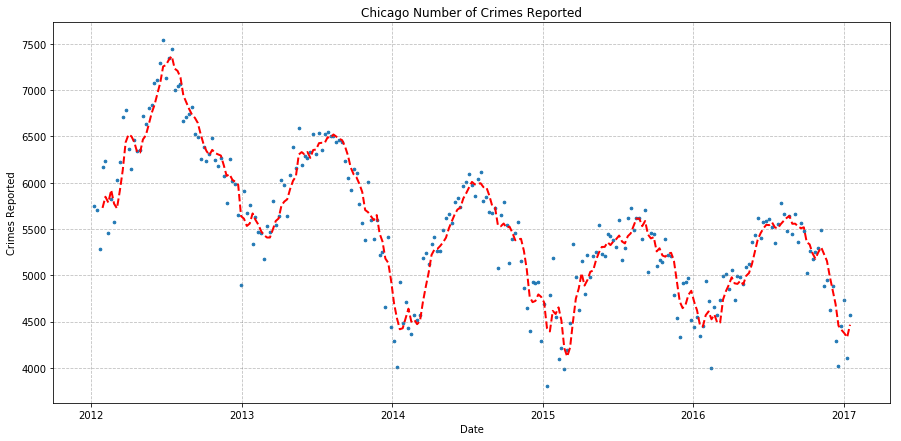

In [69]:
plt.figure(figsize = (15,7))
plt.scatter(ts_week.index.tolist(),ts_week['ID'],s = 7)

plt.plot(ts_week.index.tolist(),ts_week['ID'].rolling(window = 4).mean(), color = 'red', ls = '--', lw = 2)
plt.title('Chicago Number of Crimes Reported')
plt.ylabel('Crimes Reported')
plt.xlabel('Date')
plt.grid(alpha = .5, ls = '--', c ='grey')

### Initial Observations

We can make some assumptions such as decreasing trend and seasonality but it would be best to explore via other visualizations.

While there are definitely infinite ways to explore time series data, if the end goal is to build a model, some key things to visualize are:

- Time series plot: to visualize the dynamic and evolution of the series
- Histogram or NP Density: to visualize the distribution
- Sample ACF and PACF graphs: to examine autocorrelation and partial autocorrelation
- Scatterplot matrix on lags: an alternative way to visualize autocorrelation of the series




In [9]:
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt



def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [10]:
#ts_week = ts.set_index('Date')
#ts.resample('W',on = 'Date').sum()
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582146 entries, 0 to 582145
Data columns (total 2 columns):
Date    582146 non-null datetime64[ns]
ID      582146 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.9 MB


(<matplotlib.axes._subplots.AxesSubplot at 0x7f37ca886d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f37c289e320>)

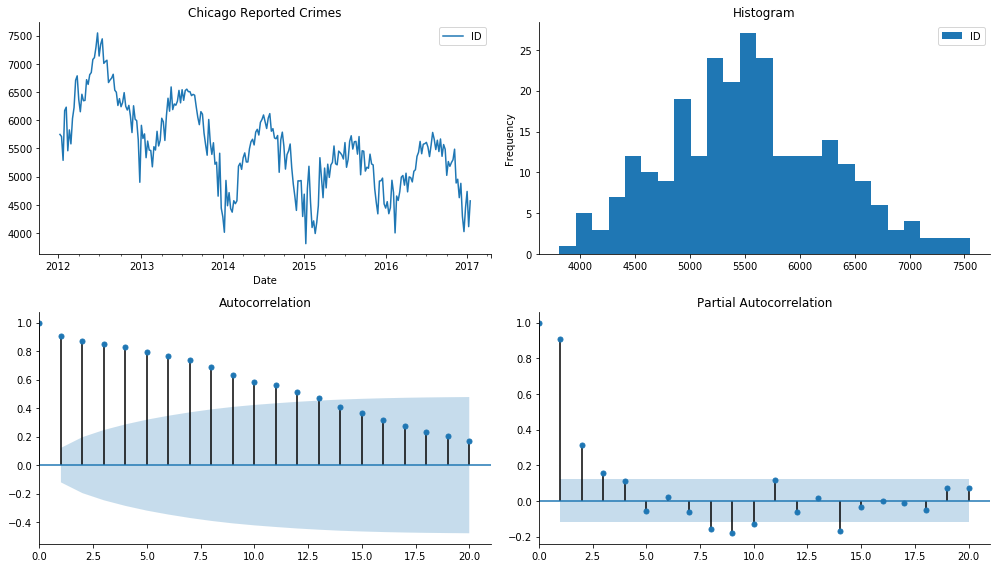

In [11]:
tsplot(ts_week,title = 'Chicago Reported Crimes',lags = 20)

### Initial Observations

- The data shows decreasing trend overtime
- There appears to be seasonality
- The autocorrelation is gradually declining
- The mean number of crimes reported per week seems to be around 5500 crimes.


## Stationarity

One of the requirements that is needed before a series can be modeled is that it has to be stationary.

Stationarity can be tested and defined more strictly but for our puproses a time series $x_t$ is said to be weakly stationary if it is mean and variance stationary and its autocovariance $Cov(x_t,x_{t+k})$ depends only the time displacement $k$ and can be written as $\gamma(k)$.

Obviously, based on the graphs above, this time series is NOT stationary. There are a couple of tricks a statistician can do in order to transform the series into a stationary one. One of the most common ways is to take the log of our observations.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f37c27d47f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f37c0ecc780>)

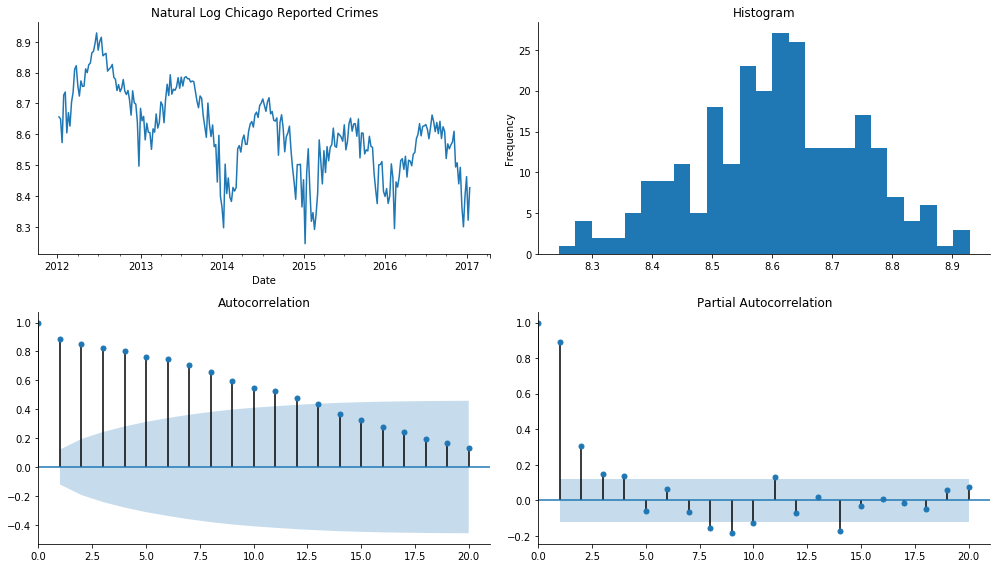

In [12]:
ts_week['ln_id']= np.log(ts_week['ID'])
tsplot(ts_week['ln_id'],title = 'Natural Log Chicago Reported Crimes',lags = 20)


The log transformation limits the effect of trend. However, the data is still not stationary. Another common transformation is to take a difference. Luckily, pandas makes this easy with the diff() function.

/home/joseph/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f37c276e978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f37c0cb7518>)

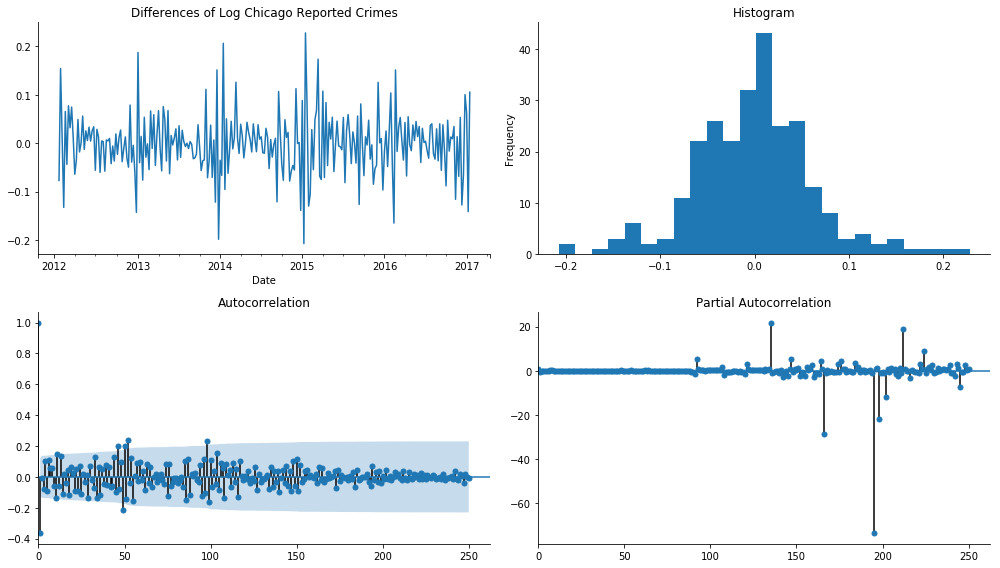

In [13]:
ln_diff = ts_week['ln_id'].diff()
ln_diff = ln_diff.dropna()


#ts_week['ln_id_diff']= ts_week['ln_id']
tsplot(ln_diff[1:],title = 'Differences of Log Chicago Reported Crimes',lags = 250)

That's more like it! For those who are already familliar with ARIMA forecasting, we will need to remember how many differences we did for our model (in this case, we did 1).

## Building the Model

The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |



Similar to that for the ARIMA models, the table below summarize the behavior of the theoretical ACF and PACF of the pure seasonal ARMA models:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(P)**     |    tails off         | cutoff after lag $P$ |
| **MA(Q)**     | cutoff after lag $Q$ |    tails off         |
| **ARMA(P,Q)** |    tails off         |    tails off         |

* **Note that we use (p,d,q) to denote the orders for the non-seasonal components of the ARIMA models and (P,D,Q,s) to denote the orders for the seasonal components of the ARIMA model.**

Using the tables above and with a little bit of trial and error, we can properly choose the parameters that best fit the data. I found the best parameters to be (1,1,1)(1,1,0,52)

In [14]:
#ts_week.head()

In [67]:
mod = sm.tsa.statespace.SARIMAX(ts_week['ln_id'][:'2015'], order=(1,1,1), seasonal_order=(1,1,0,52),simple_differencing=False) #52 for 52 weeks in a year
sarima_fit1 = mod.fit()


/home/joseph/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [16]:
pred = sarima_fit1.get_prediction(start=pd.to_datetime('2012-01-08'),
                                    end=pd.to_datetime('2017-01-15'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

In [17]:
#ts_week['ID'][:'2016']

In [18]:
pred_ci=np.exp(pred_ci)

Note on why I plotted the model starting from 2013/01/15. The prediction seems to be way too large (in the millions) on date prior which I believe is from differencing and the effect of seasonality. I'm leaving that out since it is clearly an outlier prediction

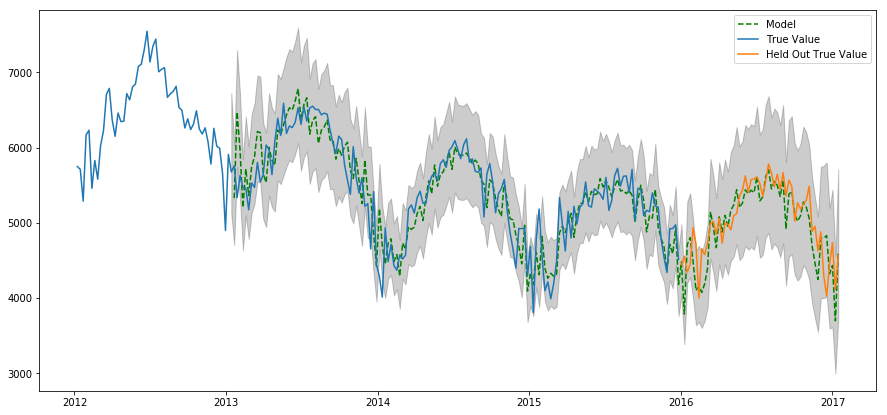

In [19]:
plt.figure(figsize = (15,7))
plt.plot(np.exp(pred_mean['2013/01/15':]),label = 'Model', ls = '--', c = 'green')
plt.plot(ts_week['ID'][:'2015'],label = 'True Value')
plt.plot(ts_week['ID']['2016':],label = 'Held Out True Value')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()

## Evaluation

In [25]:
pred_mean.tail()

2016-12-18    8.482322
2016-12-25    8.371153
2017-01-01    8.396437
2017-01-08    8.214741
2017-01-15    8.436707
Freq: W-SUN, dtype: float64

In [66]:
print(sarima_fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              ln_id   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 52)   Log Likelihood                 228.428
Date:                            Thu, 17 May 2018   AIC                           -448.856
Time:                                    22:10:02   BIC                           -436.682
Sample:                                01-08-2012   HQIC                          -443.912
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1770      0.104      1.701      0.089      -0.027       0.381
ma.L1         -0.8393      0.068   

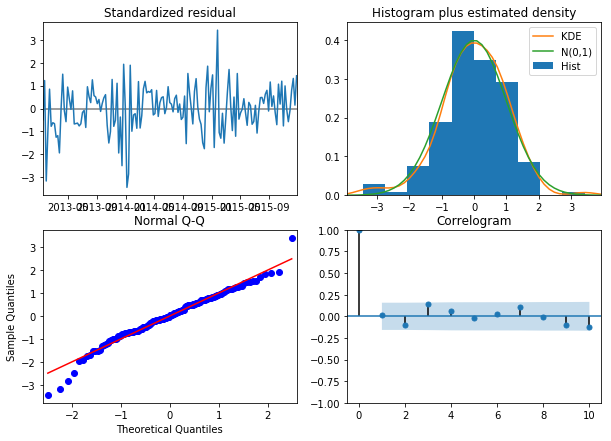

In [26]:
sarima_fit1.plot_diagnostics(figsize=(10, 7));

### Evaluation Metrics

Here are some common metrics to look at when evaulating a time series model

- Mean Absolute Percentage Error (MAPE)
    - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

- Mean Absolute Error (MAE)
    - https://en.wikipedia.org/wiki/Mean_absolute_error

- Root Mean Squared Error (RMSE)
    - https://en.wikipedia.org/wiki/Root-mean-square_deviation
    
Both MAE and RMSE are included in sklearn, a popular machine learning python library. MAPE however is not. Fortunately, we can easily write a function to calculate MAPE.

In [61]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [68]:
(np.exp(pred_mean[:'2015']).shape, ts_week['ID'][:'2015'].shape) # Check if predictions and true values are the same length

((208,), (208,))

In [65]:
insample_mape = mean_absolute_percentage_error(ts_week['ID']['2013/01/15':'2015'],np.exp(pred_mean['2013/01/15':'2015']))
insample_mae = mean_absolute_error(ts_week['ID']['2013/01/15':'2015'],np.exp(pred_mean['2013/01/15':'2015']))
insample_mse = mean_squared_error(ts_week['ID']['2013/01/15':'2015'],np.exp(pred_mean['2013/01/15':'2015']))

#outofsample_mapemean_absolute_percentage_error()
insample_mape,insample_mae,np.sqrt(insample_mse)

(4.3066267035189769, 225.76027526756326, 290.80712624115489)

In [64]:
outsample_mape = mean_absolute_percentage_error(ts_week['ID']['2016':],np.exp(pred_mean['2016':]))
outsample_mae = mean_absolute_error(ts_week['ID']['2016':],np.exp(pred_mean['2016':]))
outsample_mse = mean_squared_error(ts_week['ID']['2016':],np.exp(pred_mean['2016':]))

outsample_mape,outsample_mae,np.sqrt(outsample_mse)

(4.689613274621375, 225.11224515216733, 294.23129819046312)

According to the results above, our predictions are only about 5% off! That's pretty good in my opinion! There are other more mathematical ways to evaluate the model but MAPE seems to be the one that is most easily understood by the non-technical crowd.

## Auto Arima Forecasting

As you may have noticed, manually exploring each time series to find the appropriate parameters is very time consuming. Imagine being tasked to forecast multiple time series. Worse yet, what if the appropriate parameters change in the future? It's simply is not practical to baby-sit hundreds of models as a lone data scientist.

Luckily, there are ways to automate parameter optimization. For those of you already familliar with machine learning techniques, you can simply perform a grid-search over many combinations of the parameters and pick the best one. Here is an implementation of such a technique using Pyramid, a relatively new package for Time Series forecasting.

In [139]:
from pyramid.arima import auto_arima
stepwise_fit = auto_arima(ts_week['ln_id'], start_p=0, start_q=0, max_p=3, max_q=3, m=52,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=-525.154, BIC=-514.438, Fit time=9.900 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-538.864, BIC=-524.575, Fit time=13.499 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=-611.785, BIC=-597.496, Fit time=14.038 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 52); AIC=-609.945, BIC=-592.084, Fit time=30.744 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=-559.055, BIC=-548.338, Fit time=1.876 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=-612.522, BIC=-594.662, Fit time=22.383 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC

In [143]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  263
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                 311.261
Date:                            Sun, 13 May 2018   AIC                           -612.522
Time:                                    21:48:58   BIC                           -594.662
Sample:                                         0   HQIC                          -605.345
                                            - 263                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.799      0.072   -4.11e-05       0.001
ar.L1          0.1549      0.068      2.271      0.023       0.021       0.289
ma.L1         -0.8907      0.041    -21.982      0.000      -0.970      -0.811
ma.S.L52      -0.9885      3.584     -0.276      0.783      -8.013       6.036
sigma2         0.0020      0.007      0.282      0.778      -0.012       0.016
===================================================================================
Ljung-Box (Q):                       33.05   Jarque-Bera (JB):                12.88
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.44
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Look at that! The grid search found the same parameters we did!
